In [28]:
%config IPCompleter.greedy=True

In [29]:
# libraries
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale

## Import dataset and extract ~24% information for processing

In [30]:
# Import MNNIST dataset
MNIST_train = pd.read_csv("train.csv")

In [31]:
# taking the first 10000 rows for processing
dataset=MNIST_train.head(10000)

## check data quality

In [32]:
round((dataset.isnull().sum(axis=0)/dataset.shape[0])*100,2).sort_values(ascending=False)

pixel783    0.0
pixel267    0.0
pixel265    0.0
pixel264    0.0
pixel263    0.0
pixel262    0.0
pixel261    0.0
pixel260    0.0
pixel259    0.0
pixel258    0.0
pixel257    0.0
pixel256    0.0
pixel255    0.0
pixel254    0.0
pixel253    0.0
pixel252    0.0
pixel251    0.0
pixel250    0.0
pixel249    0.0
pixel248    0.0
pixel247    0.0
pixel246    0.0
pixel245    0.0
pixel266    0.0
pixel268    0.0
pixel390    0.0
pixel269    0.0
pixel290    0.0
pixel289    0.0
pixel288    0.0
           ... 
pixel495    0.0
pixel494    0.0
pixel493    0.0
pixel492    0.0
pixel491    0.0
pixel512    0.0
pixel513    0.0
pixel514    0.0
pixel526    0.0
pixel535    0.0
pixel534    0.0
pixel533    0.0
pixel532    0.0
pixel531    0.0
pixel530    0.0
pixel529    0.0
pixel528    0.0
pixel527    0.0
pixel525    0.0
pixel515    0.0
pixel524    0.0
pixel523    0.0
pixel522    0.0
pixel521    0.0
pixel520    0.0
pixel519    0.0
pixel518    0.0
pixel517    0.0
pixel516    0.0
label       0.0
Length: 785, dtype: floa

### There are no columns with null values. data is clean

# Data Exploration

In [33]:
dataset.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

### check distribution of columns across range of unique values for all letters

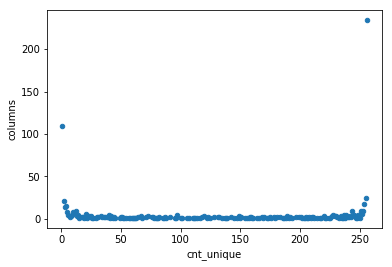

In [34]:
column_list=dataset.columns # all columns
exploration=pd.DataFrame() 
exploration['columns']=column_list
exploration['cnt_unique']=list(dataset.nunique())
exploration_a=exploration.pivot_table(values='columns',columns='cnt_unique',aggfunc='count')
exploration_a=exploration_a.T
exploration_a.reset_index(level=0, inplace=True)
exploration_a.plot.scatter(x='cnt_unique',y='columns')

## Feature creation

### we are adding another feature, where we are taking the ratio of black and white pixels for each letter. 
### The following steps are designed to identify an optimum threshold using a grid search based exploratory technique

In [35]:
# Identify the mean values of all pixels for each level
exploration_b=dataset.pivot_table(index='label',aggfunc='mean')
exploration_b.reset_index(level=0, inplace=True)
exploration_b

,label,pixel0,pixel1,pixel10,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,...,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99
0,0,0.0,0.0,0.0,6.936428,5.574168,4.528759,3.470232,1.677094,0.785066,...,0.000000,0.000000,0.255298,0.567104,0.866801,1.215943,1.279516,2.382442,3.812311,5.447023
1,1,0.0,0.0,0.0,1.871233,1.161644,0.619178,0.745205,0.236530,0.231050,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.232877,0.714155,1.811872,1.898630,1.885845
2,2,0.0,0.0,0.0,37.400000,27.461244,17.896651,11.212440,6.668900,2.711962,...,1.283254,3.387560,7.594258,13.418182,20.343541,28.704306,35.031579,42.110048,44.127273,43.411483
3,3,0.0,0.0,0.0,5.803766,4.125867,2.606541,1.439049,0.880079,0.336967,...,0.536174,0.629336,0.870168,1.585728,2.744301,5.173439,7.532210,8.192270,8.982161,7.501487
4,4,0.0,0.0,0.0,0.948294,0.631851,0.795243,1.852120,1.264736,0.773526,...,0.000000,0.000000,0.065150,0.112720,0.117890,0.402275,0.323681,0.192347,0.048604,0.342296
5,5,0.0,0.0,0.0,3.399558,3.332230,2.203091,2.264901,2.544150,2.492274,...,0.000000,0.000000,0.020971,0.054084,0.363135,0.577263,0.562914,1.278146,2.312362,2.854305
6,6,0.0,0.0,0.0,82.209372,75.834497,63.164506,45.339980,29.919242,17.364905,...,0.405783,2.530409,5.528415,11.130608,17.256231,24.878365,34.975075,47.550349,63.761715,77.253240
7,7,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,8,0.0,0.0,0.0,0.984211,1.167368,1.350526,0.866316,0.734737,0.483158,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.151579,0.426316
9,9,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [36]:
exploration_b.mean().sort_values(ascending=False)

pixel435    138.544606
pixel407    138.308065
pixel408    137.141667
pixel211    135.622182
pixel434    134.893643
pixel210    134.260164
pixel602    133.926603
pixel212    133.148241
pixel436    132.409417
pixel601    131.285857
pixel409    130.155689
pixel380    129.841472
pixel575    128.545322
pixel381    128.071503
pixel406    127.950768
pixel603    127.532915
pixel209    127.083997
pixel463    126.781861
pixel629    126.525729
pixel574    126.238404
pixel183    125.927917
pixel213    125.664927
pixel462    125.504460
pixel237    124.537310
pixel433    123.674216
pixel437    123.237234
pixel238    123.015982
pixel628    122.840033
pixel240    122.758235
pixel464    122.605753
               ...    
pixel16       0.000000
pixel54       0.000000
pixel55       0.000000
pixel559      0.000000
pixel56       0.000000
pixel560      0.000000
pixel168      0.000000
pixel169      0.000000
pixel17       0.000000
pixel57       0.000000
pixel587      0.000000
pixel336      0.000000
pixel335   

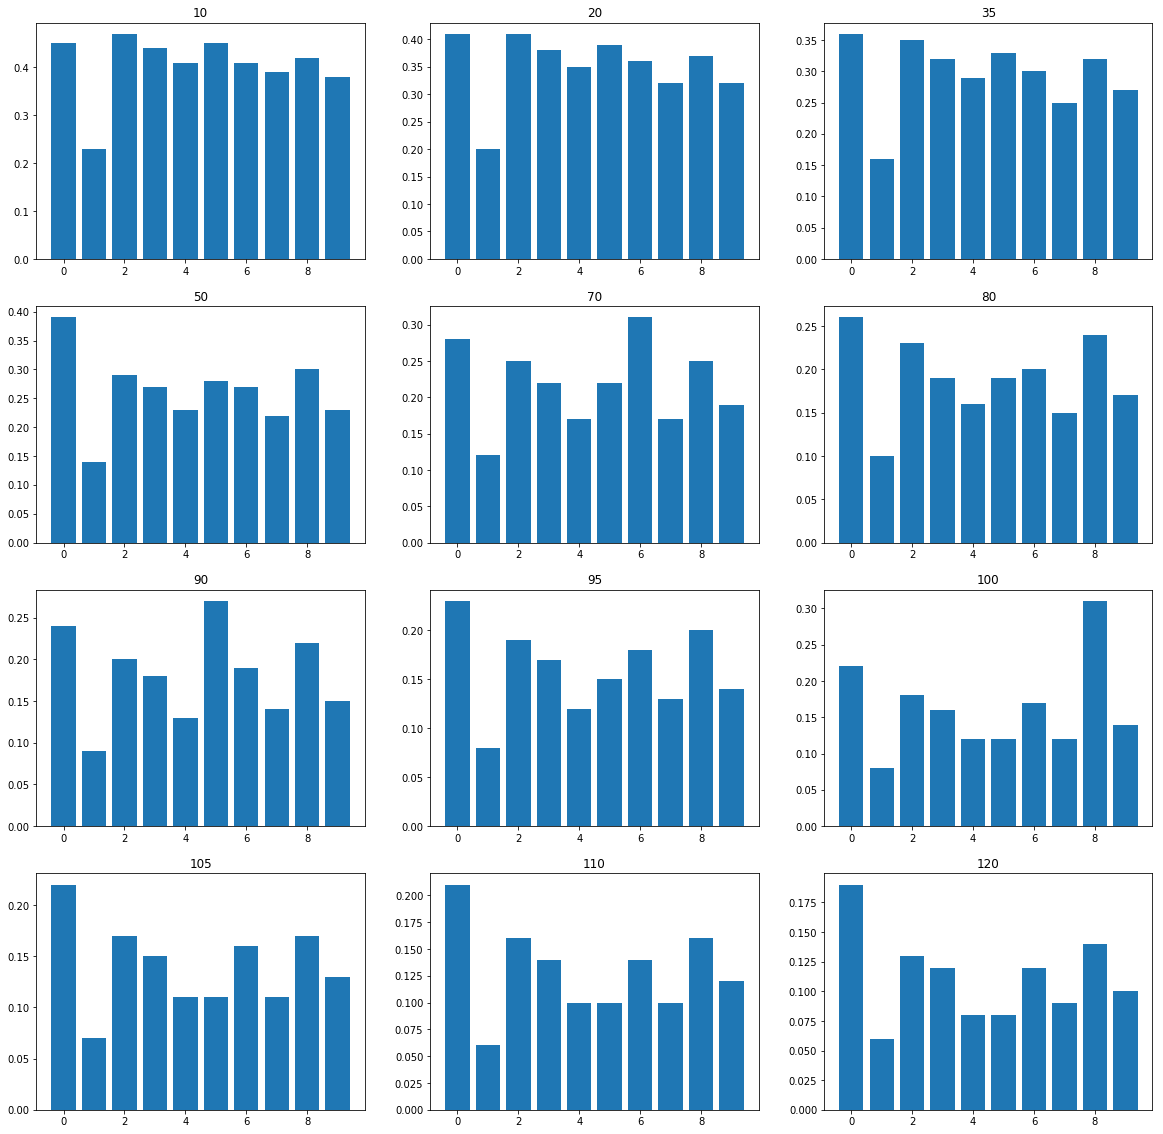

In [37]:
# Identify the threshold using search through multiple values to identify black or white cells
fig, axes = plt.subplots(nrows=4, ncols=3,figsize=(20,20))
count=0
thres=[10,20,35,50,70,80,90,95,100,105,110,120]
for i in range(4):
    for j in range(3):
        threshold = thres[count]
        exploration_b_1=exploration_b.drop(['label'],axis=1)
        exploration_b_1[exploration_b_1<threshold] = 0.0
        exploration_b_1[exploration_b_1>threshold] = 1.0
        exploration_b_1['ratio']=round((exploration_b_1.sum(axis=1))/exploration_b_1.shape[1],2)
        exploration_b_1['label']=exploration_b['label']
        exploration_b_2=exploration_b_1[['label','ratio']]
        #exploration_b_2.plot(y=["ratio"],kind="bar")
        axes[i,j].bar(exploration_b_2['label'],exploration_b_2['ratio'])
        axes[i,j].set_title(threshold)
        count=count+1
        

#### Threshold of 95 is giving best variance in the data 

In [38]:
exploration_b_1=exploration_b.drop(['label'],axis=1)
exploration_b_1[exploration_b_1<95] = 0.0
exploration_b_1[exploration_b_1>94] = 1.0
exploration_b_1['ratio']=round((exploration_b_1.sum(axis=1))/exploration_b_1.shape[1],2)
exploration_b_1['label']=exploration_b['label']
exploration_b_2=exploration_b_1[['label','ratio']]
exploration_b_2

,label,ratio
0,0,0.23
1,1,0.08
2,2,0.19
3,3,0.17
4,4,0.12
5,5,0.15
6,6,0.18
7,7,0.13
8,8,0.20
9,9,0.14


## setting threshold as 95 as this shows optimal variance in ratio distribution

In [51]:
dataset_fnl=pd.merge(dataset,exploration_b_2,how='inner',on='label')
dataset_fnl

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,ratio
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.08
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.08
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.08
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.08
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.08
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.08
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.08
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.08
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.08
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.08


In [60]:
dataset_pixls=dataset.drop(['label'],axis=1)
dataset_pixls[dataset_pixls<95] = 0.0
dataset_pixls[dataset_pixls>94] = 1.0
dataset_pixls['Ratio']=round((dataset_pixls.sum(axis=1))/dataset_pixls.shape[1],2)
dataset_pixls_fnl=dataset_pixls['Ratio']
dataset_final=pd.concat([dataset,dataset_pixls_fnl],axis=1)
dataset_final


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,Ratio
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.09
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.23
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.08
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.08
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.28
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.13
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.10
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.14
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.16
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.18


# Data Pre-processing

In [61]:
# average feature values
round(dataset_final.drop('label', axis=1).mean(),2).describe()

count    785.000000
mean      33.503006
std       42.662327
min        0.000000
25%        0.120000
50%        6.900000
75%       67.940000
max      138.870000
dtype: float64

In [62]:
from sklearn.preprocessing import scale
x=dataset_final.drop("label",axis=1)
y=dataset_final['label']
# scaling the features
X_scaled = scale(x)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 100)

# Data Modelling

In [63]:
# linear model

model_linear = SVC(kernel='linear')
model_linear.fit(X_train, y_train)

# predict
y_pred = model_linear.predict(X_test)

In [64]:
# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

accuracy: 0.910666666667 



In [65]:
# rbf model
non_linear_model = SVC(kernel='rbf')

# fit
non_linear_model.fit(X_train, y_train)

# predict
y_pred = non_linear_model.predict(X_test)

In [66]:
# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

accuracy: 0.933666666667 



In [67]:
confusion_matrix=pd.DataFrame(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))
confusion_matrix

,0,1,2,3,4,5,6,7,8,9
0,155,0,2,0,0,0,0,0,0,0
1,0,160,1,0,0,1,2,0,1,0
2,0,0,158,0,1,0,0,0,3,0
3,0,0,12,115,0,2,1,2,1,1
4,0,1,3,0,142,0,1,2,0,6
5,0,0,5,2,1,134,4,0,0,0
6,2,0,6,0,0,2,137,0,0,0
7,1,1,0,0,2,0,0,137,0,5
8,1,1,3,5,0,5,0,1,122,2
9,1,1,9,2,3,0,0,7,2,123


In [67]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 101)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [0.001,0.0001],
                     'C': [10,15,20]}]


# specify model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 15.0min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'gamma': [0.001, 0.0001], 'C': [10, 15, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [68]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results[['param_C','param_gamma','mean_test_score','mean_train_score']]

,param_C,param_gamma,mean_test_score,mean_train_score
0,10,0.001,0.938143,0.999214
1,10,0.0001,0.923571,0.961500
2,15,0.001,0.937571,0.999750
3,15,0.0001,0.925857,0.967929
4,20,0.001,0.937571,0.999929
5,20,0.0001,0.926286,0.972750


### Best fit is coming at C=15, gamma = 0.001

In [58]:
# final model
# model
model = SVC(C=15, gamma=0.001, kernel="rbf")

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# metrics
print("accuracy", metrics.accuracy_score(y_test, y_pred), "\n")

accuracy 0.95 



In [47]:
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred))

,0,1,2,3,4,5,6,7,8,9
0,288,0,3,0,0,0,1,0,0,0
1,0,343,2,0,1,0,3,0,0,1
2,3,0,306,2,3,0,0,2,2,0
3,0,0,8,280,0,3,0,1,3,2
4,0,1,4,1,265,0,1,1,0,6
5,2,1,5,7,0,280,2,1,1,1
6,3,0,4,0,0,2,294,0,1,0
7,1,1,9,1,4,0,0,287,0,5
8,0,0,4,2,0,8,1,0,262,3
9,1,1,7,2,5,2,0,9,0,245
